Importing all Required Libraries

In [2]:
!pip install unet --quiet
from unet import UNet
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import numpy as np
import PIL
import cv2
from google.colab.patches import cv2_imshow
from torchvision import transforms
from PIL import Image
device = torch.device("cpu")


Reading my test image and displaying it

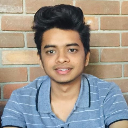

In [3]:
image = cv2.imread("ishan.jpg")
image = cv2.resize(image, (128, 128))

transform = transforms.ToTensor()
tensor_image = transform(image)


numpy_image = tensor_image.permute(1, 2, 0).numpy()

# Scale the values back to the range [0, 255] for displaying with cv2
scaled_image = (numpy_image * 255).astype('uint8')
cv2_imshow(scaled_image)

Initializing betas with dummys for 5 time stamps (T = 0 , 1, ..4)

In [4]:
betas = torch.tensor([0.05, 0.1, 0.5, 0.2, 0.25])
# Just initialing small dummy betas

Taking timestamps from 0 - 4

In [5]:
t = torch.tensor([4])
# taking a random time stamp t as 4


As we compare the initial formula of forward propogation with the generic one given in Readme.md from there we are deducing the value of alpha to be beta-1


In [6]:
# taking generic formula at timestamp t
# mean is sqrt(alpha_hat_t) *  x0
# variance is (1-alpha_hat_t) * I
# if we compare q(xt|x0) and q(xt|x_t-1) we will get alphas = (1-betas)

alphas = (1-betas)
alphas

tensor([0.9500, 0.9000, 0.5000, 0.8000, 0.7500])

product of previous respective value of alpha at time stamp t is the alpha_hat value alpha_hat = prod(alphat[i]){i=0 -> T}

In [7]:
# alpha_hat_t is product of alpha_t through the enttire course of time

alpha_hat = torch.cumprod(alphas, axis = 0)
alpha_hat

tensor([0.9500, 0.8550, 0.4275, 0.3420, 0.2565])

In [8]:
tensor_image.size(), alpha_hat.size()

(torch.Size([3, 128, 128]), torch.Size([5]))

gathering the t'th timestamp value of alpha_hat (like alphat_hat[t])



In [9]:
# picking those alpha_hat values for defined timestamp

alpha_res = alpha_hat.gather(-1, t) #axis = -1 is default axis
alpha_res

tensor([0.2565])

In [10]:
alpha_res = alpha_res.reshape(-1, 1, 1)
alpha_res.size()

torch.Size([1, 1, 1])

calculating the mean and variance along with initializing random noise for the distribution

In [11]:
noise = torch.rand_like(tensor_image)
mean = alpha_res.sqrt() * tensor_image
variance = torch.sqrt(1-alpha_res)* noise

In [12]:
x_t = mean + variance

In [13]:
x_t

tensor([[[0.8784, 0.5180, 1.0608,  ..., 1.0582, 1.1452, 1.0712],
         [0.4936, 1.0701, 1.1735,  ..., 1.1168, 1.0713, 0.6625],
         [0.6073, 1.0449, 1.1676,  ..., 0.8123, 0.3818, 0.9401],
         ...,
         [0.8876, 0.3958, 0.4503,  ..., 0.9115, 0.8391, 0.3690],
         [0.3096, 0.2449, 0.7490,  ..., 0.7893, 0.9407, 0.6607],
         [0.3604, 0.1254, 0.3772,  ..., 1.0028, 0.3091, 0.6796]],

        [[0.9669, 0.3789, 1.1087,  ..., 0.8399, 1.1712, 0.8545],
         [0.5294, 0.8903, 0.9116,  ..., 1.0352, 1.0546, 1.0701],
         [0.9398, 0.6911, 0.5488,  ..., 0.3589, 1.1532, 0.3475],
         ...,
         [0.5063, 0.8165, 0.8664,  ..., 0.4157, 0.3481, 1.1195],
         [0.0775, 0.7013, 0.2351,  ..., 1.1770, 0.7132, 0.6582],
         [0.5547, 0.5412, 0.8479,  ..., 1.1667, 0.3712, 0.9096]],

        [[0.6299, 0.4168, 0.4858,  ..., 0.8659, 0.6434, 0.4699],
         [0.5691, 0.9658, 0.5238,  ..., 0.5194, 1.1802, 1.0755],
         [0.5858, 0.7385, 1.0744,  ..., 0.4789, 0.7784, 0.

the image at time stamp 4 when it's added noise to it.


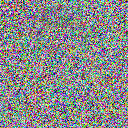

In [14]:
numpy_image = x_t.permute(1, 2, 0).numpy()

# Scale the values back to the range [0, 255] for displaying with cv2
scaled_image = (numpy_image * 255).astype('uint8')
cv2_imshow(scaled_image)

# hence the imputed image at time stamp 4

Assembling down of entire above procedure into a function forward function

In [15]:
# Creating all this in a forward function
def forward_propagation(x0, t, betas = torch.linspace(0.0, 1.0, 5)):
  noise = torch.rand_like(x0)
  alphas = 1- betas
  alpha_hat = torch.cumprod(alphas, axis = 0)
  alpha_hat_t = alpha_hat.gather(-1, t).reshape(-1,1,1,1)

  mean = alpha_hat_t.sqrt() * x0
  variance = torch.sqrt(1-alpha_hat_t) * noise
  x_t = mean + variance
  return x_t, noise

Transforms are used to resize of convert the arrays to tensors and various other operations before sending the image to training

In [39]:
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(), # PIL IMAGE to tensor, it is normalisez (0,....1)
        transforms.Lambda(lambda t: (t*2) - 1) # to convert it into -1 to 1 range where mean and variance lies
    ]
)

reverse_transform = transforms.Compose(
    [
        transforms.Lambda(lambda t : (t+1)/2),
        transforms.Lambda(lambda t : t.permute(1,2,0)), # rearranges dimension in specified order (x, y, channel)
        transforms.Lambda(lambda t : t*255.),
        transforms.Lambda(lambda t : t.numpy().astype('uint8')),
        transforms.ToPILImage()
    ]
)

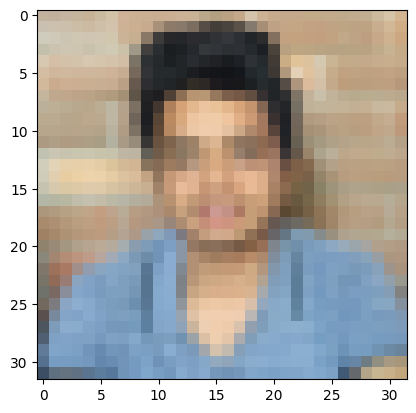

In [17]:
img = Image.open("ishan.jpg")
torch_image = transform(img)
plt.imshow(reverse_transform(torch_image))

The Below code block shows the added noise from t=0 to t= 4 and it's representation below.

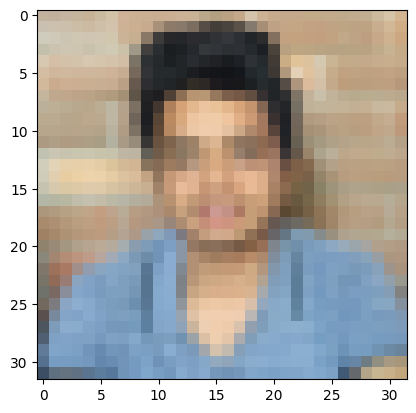

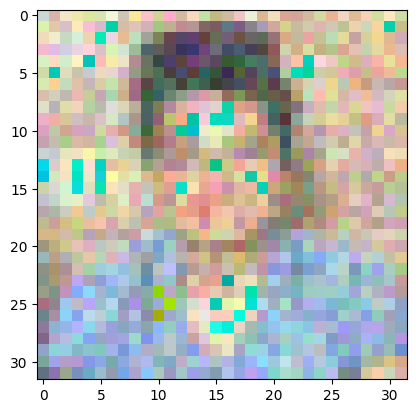

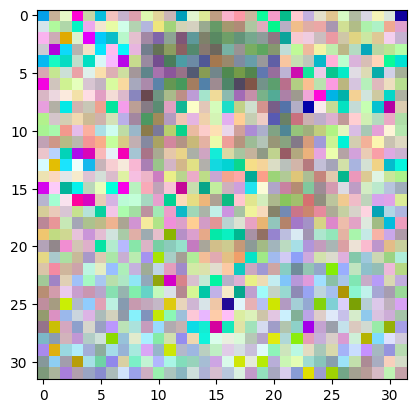

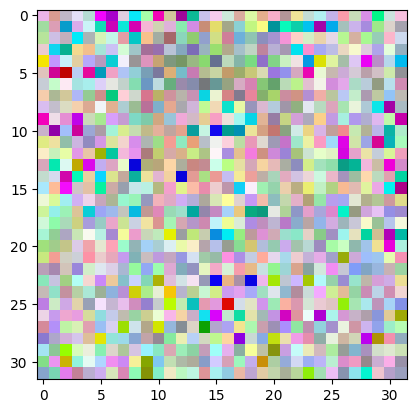

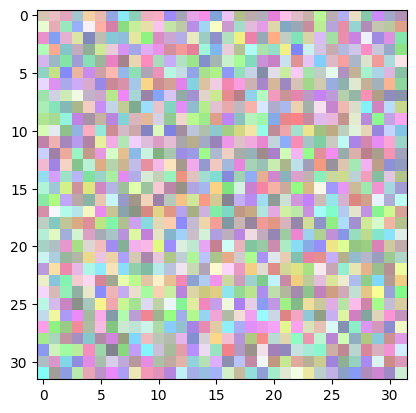

In [18]:
timestamps = torch.tensor([0,1,2,3,4])
batch_images = torch.stack([torch_image]*5)
all_images, noise = forward_propagation(batch_images, timestamps)

for img in all_images:
  plt.imshow(reverse_transform(img))
  plt.show()

Initializig a dummy random U-Net as torch unet was throwing exceptions while training.

In [19]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)


    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

Creating the class of Diffusion model with forward propogation along with the backward with reference of the given formula in the Readme.md and the above procedure (taking the entire above code and wrapping it into one class)

In [20]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns
        the denoised image.
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

Training the Distorted Image with Unets. Initially tried with epocs 500 which resulted in overfitting hence decreased the no. of epochs. Also initializing the learning rate to be 0.001 (of Adam Optimizer)

In [21]:
NO_EPOCHS = 400
PRINT_FREQUENCY = 10
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True
IMAGE_SHAPE = (32, 32)

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 1.0330792665481567


<Figure size 500x500 with 0 Axes>

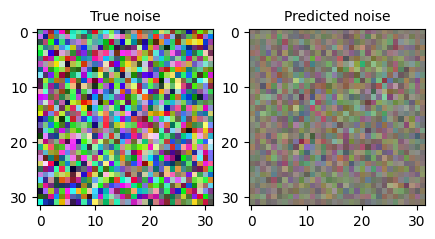

---
Epoch: 50 | Train Loss 0.1049656867980957


<Figure size 500x500 with 0 Axes>

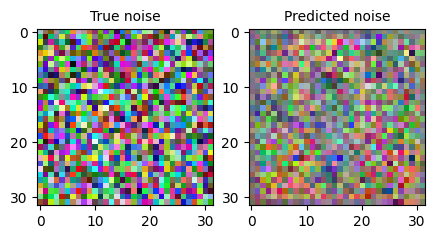

---
Epoch: 100 | Train Loss 0.03967132791876793


<Figure size 500x500 with 0 Axes>

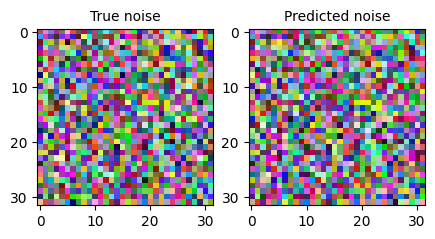

---
Epoch: 150 | Train Loss 0.03969892859458923


<Figure size 500x500 with 0 Axes>

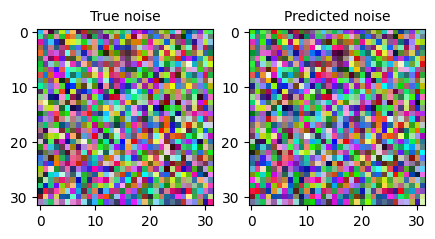

---
Epoch: 200 | Train Loss 0.02508562244474888


<Figure size 500x500 with 0 Axes>

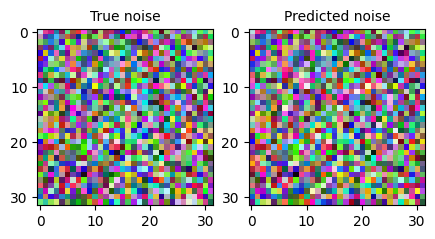

---
Epoch: 250 | Train Loss 0.016640936955809593


<Figure size 500x500 with 0 Axes>

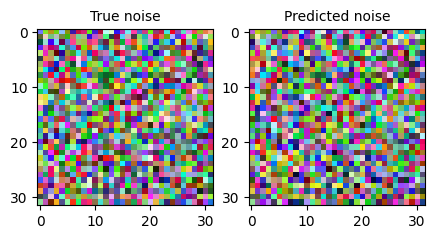

---
Epoch: 300 | Train Loss 0.0131769934669137


<Figure size 500x500 with 0 Axes>

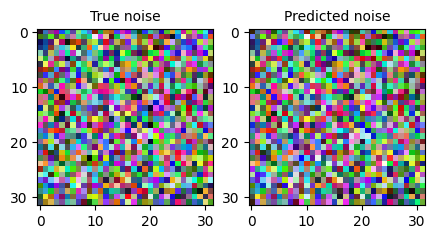

KeyboardInterrupt: ignored

In [23]:
diffusion_model = DiffusionModel()

for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []

    batch = torch.stack([torch_image] * BATCH_SIZE)
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

    batch_noisy, noise = diffusion_model.forward(batch, t, device)
    predicted_noise = unet(batch_noisy, t)

    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise)
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()
    if np.mean(mean_epoch_loss) <= 0.001:
      break

    if epoch % 50 == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plt.figure(figsize=(5,5))
                f, ax = plt.subplots(1, 2, figsize = (5,5))
                ax[0].imshow(reverse_transform(noise[0]))
                ax[0].set_title(f"True noise", fontsize = 10)
                ax[1].imshow(reverse_transform(predicted_noise[0]))
                ax[1].set_title(f"Predicted noise", fontsize = 10)
                plt.show()

Testing a random image with the given model.

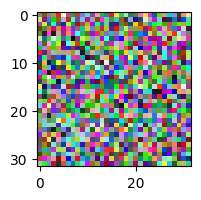

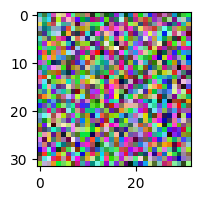

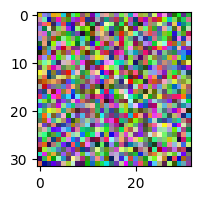

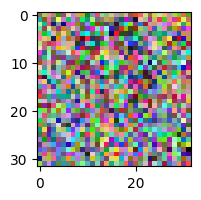

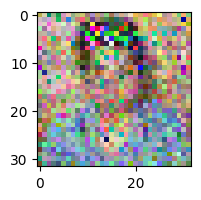

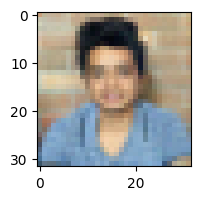

In [24]:
with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())
        if i % 50 == 0:
            plt.figure(figsize=(2,2))
            plt.imshow(reverse_transform(img[0]))
            plt.show()


Some part of the code base is written with reference to a Nvdia Developer. And  further more the training can happen taking entire training set of images which results in further more enhanced results.

